In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# https://www.kaggle.com/datasets/crowww/a-large-scale-fish-dataset

In [32]:
feature = pd.read_pickle("feature2.pkl")
target = pd.read_pickle("target2.pkl")

In [33]:
x_train, x_test, y_train, y_test = train_test_split(feature, target, test_size=0.1, random_state=42, stratify=target)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.1, random_state=42, stratify=y_test)

In [34]:
x_train.shape, x_valid.shape, x_test.shape

((8100, 2655), (810, 2655), (90, 2655))

In [35]:
x_train = torch.tensor(x_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
x_valid = torch.tensor(x_valid.values, dtype=torch.float32)
y_valid = torch.tensor(y_valid.values, dtype=torch.long)
x_test = torch.tensor(x_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.long)

In [36]:
# 데이터셋 생성
import torch.utils.data.dataloader as dataloader
import torch.utils.data.dataset as dataset

class MyDataset(dataset.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [37]:
dataset_train = MyDataset(x_train, y_train)
dataset_test = MyDataset(x_test, y_test)
dataset_valid = MyDataset(x_valid, y_valid)

In [38]:
x_train.shape

torch.Size([8100, 2655])

In [39]:
class model(nn.Module): # 가중치 초기화 
    def __init__(self):
        super(model, self).__init__()
        self.fc1 = nn.Linear(2655, 400)
        self.fc2 = nn.Linear(400, 9)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [40]:
model2 = model()
for name, child in model2.named_children():
    nn.init.kaiming_normal_(child.weight)
optimizer = optim.ASGD(model2.parameters())
criterion = nn.CrossEntropyLoss()

train_loader = dataloader.DataLoader(dataset_train, batch_size=100, shuffle=True, drop_last=True)
test_loader = dataloader.DataLoader(dataset_test, batch_size=100, shuffle=True, drop_last=True)
valid_loader = dataloader.DataLoader(dataset_valid, batch_size=100, shuffle=True, drop_last=True)

In [41]:
from torchmetrics.functional.classification import accuracy, f1_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
model2.train()
valid_score=[]
train_score=[]

scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

for epoch in range(200):
    
    for x,y in train_loader:
        output = model2(x)
        loss = criterion(output, y.squeeze())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():        
        print(f"================================={epoch}=================================")
        output = model2(x_train)
        acc = accuracy(output, y_train.squeeze(), task="multiclass", num_classes=9, average="macro")
        f1 = f1_score(output, y_train.squeeze(), task="multiclass", num_classes=9, average="macro")
        train_score.append([acc, f1])
        print(f"train => acc : {acc}, f1 : {f1}")
        
        
        output = model2(x_valid)
        print(f"=================================valid score=================================")
        acc2 = accuracy(output, y_valid.squeeze(), task="multiclass", num_classes=9, average="macro")
        f12 = f1_score(output, y_valid.squeeze(), task="multiclass", num_classes=9, average="macro")
        valid_score.append([acc2, f12])
        print(f"valid => acc : {acc2}, f1 : {f12}")
    
    scheduler.step(loss)
    if scheduler.num_bad_epochs >= scheduler.patience:
        print(f"Early stopping at epoch {epoch}")
        break


=================================0=================================
train => acc : 0.23407407104969025, f1 : 0.16501915454864502
=================================valid score=================================
valid => acc : 0.23456791043281555, f1 : 0.1666724532842636
=================================1=================================
train => acc : 0.31913578510284424, f1 : 0.2397383451461792
=================================valid score=================================
valid => acc : 0.3148147761821747, f1 : 0.23756368458271027
=================================2=================================
train => acc : 0.35185182094573975, f1 : 0.2833571135997772
=================================valid score=================================
valid => acc : 0.34197530150413513, f1 : 0.2766697108745575
=================================3=================================
train => acc : 0.38049378991127014, f1 : 0.3392540514469147
=================================valid score=============================

In [42]:
torch.save(model2,"./ASGD_model2.pth")

In [43]:
import torch
from torchmetrics.functional.classification import accuracy, f1_score
model2=model()
for name, child in model2.named_children():
    nn.init.xavier_uniform_(child.weight)
model2 = torch.load("./ASGD_model2.pth")

output = model2(x_test)
print(f"=================================test score=================================")
print(accuracy(output, y_test.squeeze(), task="multiclass", num_classes=9, average="macro"))
print(f1_score(output, y_test.squeeze(), task="multiclass", num_classes=9, average="macro"))

=================================test score=================================
tensor(0.7333)
tensor(0.7337)


In [44]:
train_acc = np.array(train_score)[:,0]
train_f1 = np.array(train_score)[:,1]

valid_acc = np.array(valid_score)[:,0]
valid_f1 = np.array(valid_score)[:,1]

In [45]:
train_score, valid_score

([[tensor(0.2341), tensor(0.1650)],
  [tensor(0.3191), tensor(0.2397)],
  [tensor(0.3519), tensor(0.2834)],
  [tensor(0.3805), tensor(0.3393)],
  [tensor(0.4043), tensor(0.3742)],
  [tensor(0.4226), tensor(0.4010)],
  [tensor(0.4344), tensor(0.4177)],
  [tensor(0.4579), tensor(0.4414)],
  [tensor(0.4677), tensor(0.4542)],
  [tensor(0.4751), tensor(0.4611)],
  [tensor(0.4841), tensor(0.4737)],
  [tensor(0.4927), tensor(0.4847)],
  [tensor(0.5025), tensor(0.4963)],
  [tensor(0.5144), tensor(0.5074)],
  [tensor(0.5215), tensor(0.5134)],
  [tensor(0.5319), tensor(0.5257)],
  [tensor(0.5417), tensor(0.5394)],
  [tensor(0.5494), tensor(0.5464)],
  [tensor(0.5547), tensor(0.5512)],
  [tensor(0.5636), tensor(0.5592)],
  [tensor(0.5716), tensor(0.5680)],
  [tensor(0.5772), tensor(0.5757)],
  [tensor(0.5831), tensor(0.5824)],
  [tensor(0.5926), tensor(0.5928)],
  [tensor(0.5928), tensor(0.5896)],
  [tensor(0.5979), tensor(0.5954)],
  [tensor(0.6056), tensor(0.6029)],
  [tensor(0.6131), tensor(0.

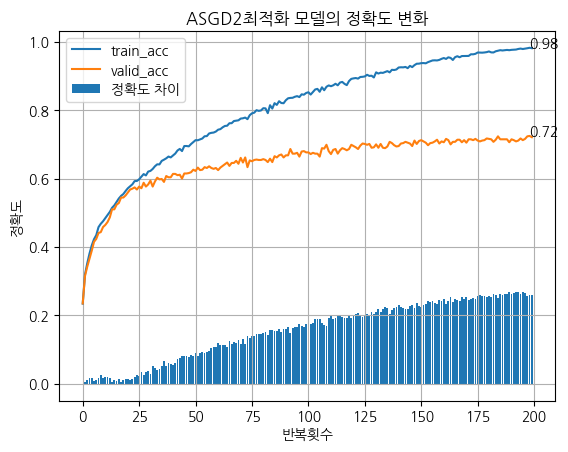

In [47]:
import matplotlib.pyplot as plt
import koreanize_matplotlib

plt.plot(train_acc, label="train_acc")
plt.plot(valid_acc, label="valid_acc")
plt.bar(range(200),train_acc-valid_acc, label="정확도 차이")
plt.legend()
plt.title("ASGD2최적화 모델의 정확도 변화")
plt.text(np.argmax(train_acc), np.max(train_acc), f"{np.max(train_acc):.2f}")
plt.text(np.argmax(valid_acc), np.max(valid_acc), f"{np.max(valid_acc):.2f}")
plt.xlabel("반복횟수")
plt.ylabel("정확도")
plt.grid()
plt.show()

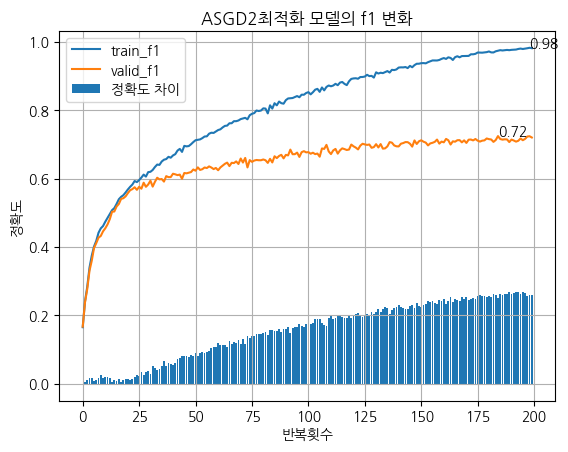

In [48]:
import matplotlib.pyplot as plt
import koreanize_matplotlib

plt.plot(train_f1, label="train_f1")
plt.plot(valid_f1, label="valid_f1")
plt.bar(range(200),train_acc-valid_acc, label="정확도 차이")
plt.legend()
plt.title("ASGD2최적화 모델의 f1 변화")
plt.xlabel("반복횟수")
plt.ylabel("정확도")
plt.text(np.argmax(train_f1), np.max(train_f1), f"{np.max(train_f1):.2f}")
plt.text(np.argmax(valid_f1), np.max(valid_f1), f"{np.max(valid_f1):.2f}")
plt.grid()
plt.show()

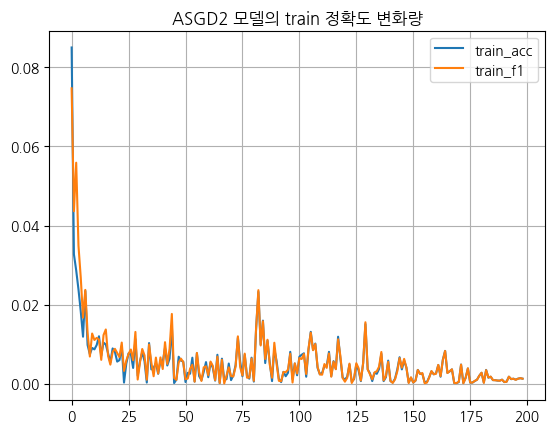

In [49]:
plt.plot(np.abs(train_acc[:-1]-train_acc[1:]), label="train_acc")
plt.plot(np.abs(train_f1[:-1]-train_f1[1:]), label="train_f1")
plt.title("ASGD2 모델의 train 정확도 변화량")
plt.legend()
plt.grid()
plt.show()

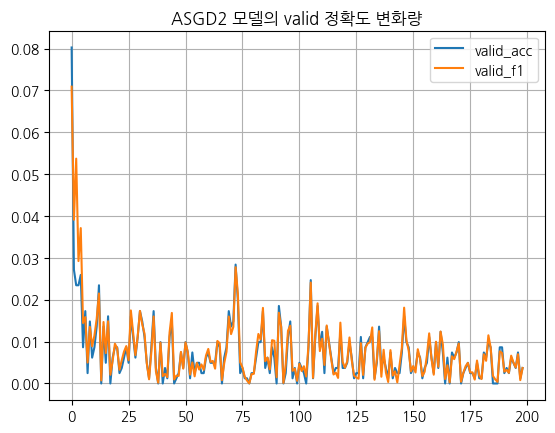

In [50]:
plt.plot(np.abs(valid_acc[:-1]-valid_acc[1:]), label="valid_acc")
plt.plot(np.abs(valid_f1[:-1]-valid_f1[1:]), label="valid_f1")
plt.title("ASGD2 모델의 valid 정확도 변화량")
plt.legend()
plt.grid()
plt.show()